# Find ICESat-2 Snow-On Dates

In [ ]:
!pip install astropy

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#import scipy.stats
#import contextily as cx
#from matplotlib_scalebar.scalebar import ScaleBar
import rasterio as rio
#from rasterio import features
#from rasterio.plot import show
#import rioxarray
from astropy.time import Time
from datetime import datetime
import pickle
#from imview.lib import pltlib
#import hvplot.pandas
#from holoviews.element.tiles import EsriImagery, StamenTerrain
#from geoviews import opts, tile_sources as gvts

In [14]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [15]:
fn = '../../../data/snotel_depths.pkl'
gm_sntl = pickle.load(open(fn, 'rb'))

<AxesSubplot:xlabel='Date'>

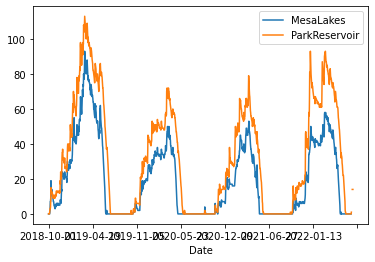

In [16]:
gm_sntl.plot()

In [17]:
gm_sntl.head(2)

,MesaLakes,ParkReservoir
Date,,
2018-10-01,0.0,0.0
2018-10-02,0.0,0.0


In [18]:
gm_sntl = gm_sntl * 2.54/100
gm_sntl.index = pd.DatetimeIndex(gm_sntl.index)

In [19]:
add_dowy(gm_sntl)
gm_sntl.head()

Adding Day of Water Year (DOWY)


,MesaLakes,ParkReservoir,doy,decyear,dowy
Date,,,,,
2018-10-01,0.0,0.0,274,2018.747945,1
2018-10-02,0.0,0.0,275,2018.750685,2
2018-10-03,0.0,0.0,276,2018.753425,3
2018-10-04,0.0,0.0,277,2018.756164,4
2018-10-05,0.0,0.0,278,2018.758904,5


In [26]:
idx_st = (gm_sntl[['MesaLakes','ParkReservoir']] < 0.1).all(axis=1)
idx_st

Date
2018-10-01     True
2018-10-02     True
2018-10-03     True
2018-10-04     True
2018-10-05     True
              ...  
2022-07-09    False
2022-07-10    False
2022-07-11    False
2022-07-12    False
2022-07-13    False
Length: 1382, dtype: bool

<AxesSubplot:>

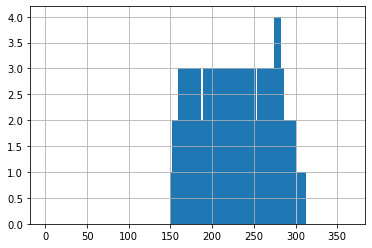

In [27]:
gm_sntl[idx_st]['doy'].hist(bins=365, range=(0,365))

In [28]:
snowfree_doy_range = (150,310)

In [43]:
atl06sr_gdf = pickle.load(open('../../../data/IS2_snow_depth', 'rb'))

In [44]:
atl06sr_gdf.head(2)

,time,h_mean,rms_misfit,delta_time,h_sigma,rgt,n_fit_photons,pflags,dh_fit_dx,spot,...,dh_fit_dy,distance,geometry,year,month,day,lat,lon,ASO_3M_PCDTM_USCOGM_20160926_20160926,diff
0,2018-11-15 21:07:35.507301452,2980.594716,0.141154,2.755126e+07,0.025316,737,34,0,0.009144,6,...,0.0,4.338665e+06,POINT (-108.11390 38.99189),2018.0,11.0,15.0,38.991887,-108.113899,2980.455078,0.139638
1,2018-11-15 21:07:35.510113648,2980.577977,0.163428,2.755126e+07,0.043345,737,20,0,-0.002196,6,...,0.0,4.338685e+06,POINT (-108.11392 38.99207),2018.0,11.0,15.0,38.992066,-108.113920,2980.770020,-0.192042


In [46]:
atl06sr_gdf.index = pd.DatetimeIndex(atl06sr_gdf.time)

In [47]:
add_dowy(atl06sr_gdf)

Adding Day of Water Year (DOWY)


In [48]:
idx = (atl06sr_gdf['doy'] >= snowfree_doy_range[0]) & (atl06sr_gdf['doy'] <= snowfree_doy_range[1])

In [49]:
atl06sr_gdf['snow_presence'] = ""
atl06sr_gdf.loc[idx, 'snow_presence'] = 0
atl06sr_gdf.loc[~idx, 'snow_presence'] = 1

In [51]:
atl06sr_gdf.tail(2)

,time,h_mean,rms_misfit,delta_time,h_sigma,rgt,n_fit_photons,pflags,dh_fit_dx,spot,...,month,day,lat,lon,ASO_3M_PCDTM_USCOGM_20160926_20160926,diff,doy,decyear,dowy,snow_presence
time,,,,,,,,,,,,,,,,,,,,,
2022-03-07 23:39:20.734443568,2022-03-07 23:39:20.734443568,3177.272823,0.127930,1.319316e+08,0.017406,1156,56,0,-0.003190,4,...,3.0,7.0,38.998473,-108.078077,3175.211914,2.060909,66,2022.180783,158,1
2022-03-07 23:39:20.737259424,2022-03-07 23:39:20.737259424,3177.338975,0.113893,1.319316e+08,0.018103,1156,51,0,0.009797,4,...,3.0,7.0,38.998293,-108.078098,3175.371094,1.967882,66,2022.180783,158,1


In [52]:
with open('../../../data/IS2_snow_depth.pkl', 'wb') as f:
    pickle.dump(atl06sr_gdf, f)